# SD201 project

- Create dataset from scraping with steam api
- Make apriori algorithm on bought games
- Make knn algorithm on hours played
- Use steam api to make recommendations to a player

# Formulate the question

Knowing the games someone bought and how many hours they played it on Steam, what are the other games they could like and thus potentially buy ?

# Finding the dataset

We will use our own dataset created from scratch using Steam API in order to make predictions, so that the dataset is more complete and more recent.

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_json('SteamGameData.json')

In [4]:
df.head()

,steamid,appid,total_playtime
0,76561198006667424,240,2677
1,76561198006667424,4000,57279
2,76561198006667424,4760,19541
3,76561198006667424,4770,1720
4,76561198006667424,10500,35248


Here we have appids and not game names, which is not really clear for the user. However, as the dataset is really huge (see below), we will not replace appids by game names right now, we will only replace them when making predictions.

In [5]:
df.describe()

,steamid,appid,total_playtime
count,1.341741e+06,1.341741e+06,1.341741e+06
mean,7.656120e+16,4.497420e+05,1.949825e+03
std,1.936204e+08,3.741208e+05,1.489921e+04
min,7.656120e+16,1.000000e+01,0.000000e+00
25%,7.656120e+16,2.237100e+05,0.000000e+00
50%,7.656120e+16,3.515100e+05,3.500000e+01
75%,7.656120e+16,6.015100e+05,4.360000e+02
max,7.656120e+16,2.165610e+06,1.853626e+06


The dataset cumulates 2 000 000 hours played, which seems enough, and we will check the number of users when the data will be a little bit cleaner.

# Cleaning the data

## Renaming the columns

In [6]:
df.columns = ['id','game','hours_played']
df.head()

,id,game,hours_played
0,76561198006667424,240,2677
1,76561198006667424,4000,57279
2,76561198006667424,4760,19541
3,76561198006667424,4770,1720
4,76561198006667424,10500,35248


In [7]:
df['id'].nunique()

8934

In [16]:
df['game'].nunique()

23186

We have 8934 users and 23186 games in the dataset, which seems to be a good start to create recommendations. Indeed, it is less than the kaggle dataset, but with players that play a lot more (10x more time played in total), which may give better results!

## Look out for NaN values

In [8]:
df.isnull().values.any()

False

There are no NaN values in the dataset

In [9]:
played_games = df
played_games.head()

,id,game,hours_played
0,76561198006667424,240,2677
1,76561198006667424,4000,57279
2,76561198006667424,4760,19541
3,76561198006667424,4770,1720
4,76561198006667424,10500,35248


## Standardizing the data

We want to standardize the hours played so that games with higher average time played will not mess with the predictions.  

However, it is important to take care about the split between training, validation and testing. Indeed, if we standardize the whole dataset, the training set will impact the other two which is something we absolutely want to avoid.  

Thus, we will firstly standardize the whole dataset for visualization purpose, but then we will only standardize the training set, and use this standardization for each test in each notebook.  

To do so, we use the means and stds of each game to standardize them.   
In particular, we will standardize the data not to be too much affected by outliers.  


In [10]:
standardization_dict = dict()
for game_name, s in played_games.groupby('game')['hours_played']:
    standardization_dict[game_name]=dict()
    series = s[s>0.0]  #take only games played
    standardization_dict[game_name]['average'] = series.mean()
    if series.std() > 0 : #for some games that are not much played, std is 0 which creates errors
        standardization_dict[game_name]['std'] = series.std()
    else:
        standardization_dict[game_name]['std'] = 1e-8

def standardize(game, hours):
    return (hours - standardization_dict[game]['average'])/standardization_dict[game]['std']

In [11]:
standardized = played_games.copy()

standardized['hours_played'] = standardized.apply(lambda x : standardize(x.game, x.hours_played),axis=1)
standardized.head()

,id,game,hours_played
0,76561198006667424,240,-0.330675
1,76561198006667424,4000,0.297830
2,76561198006667424,4760,4.815400
3,76561198006667424,4770,3.924549
4,76561198006667424,10500,3.799199


# Visualizing the data

In [12]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Density of hours played by player')

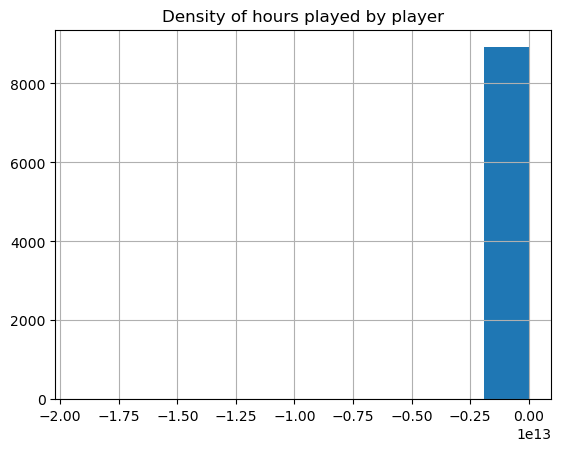

In [13]:
plt.figure()
standardized.groupby(['id'])['hours_played'].sum().hist()
plt.title('Density of hours played by player')

Almost everyone in this dataset plays around the average played time of each game.

Text(0.5, 1.0, 'Density of games owned by player')

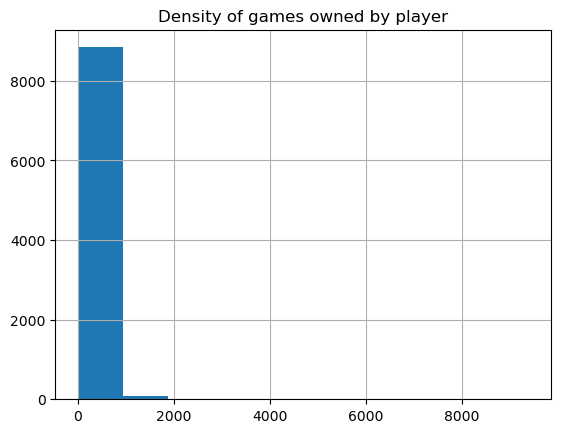

In [14]:
plt.figure()
played_games.groupby(['id'])['game'].count().hist()
plt.title('Density of games owned by player')

It seems that the distribution is exponential, as in the kaggle dataset, but here most of players have played a lot of games.  
Let's compute the mean of games played.

In [15]:
played_games.groupby(['id'])['game'].count().mean()

150.183680322364

We see that we have a dataset composed of players that play a lot of games in comparison with the kaggle dataset. It is logical because with the method we used, taking friends of friends of friends..., we gather players that use a lot the platform, while we can suppose that the kaggle dataset is composed by a majority of players that only played one game for instance.

Text(0.5, 1.0, 'Density of hours played by outlier players')

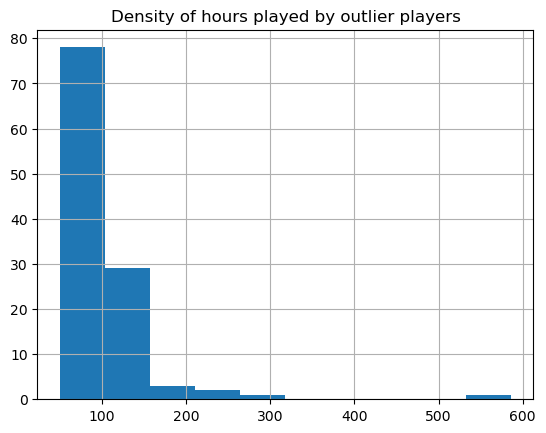

In [48]:
plt.figure()
standardized.groupby(['id'])['hours_played'].sum().loc[(standardized.groupby(['id'])['hours_played'].sum()>50)].hist()
plt.title('Density of hours played by outlier players')

Text(0.5, 1.0, 'Density of games owned by outlier players')

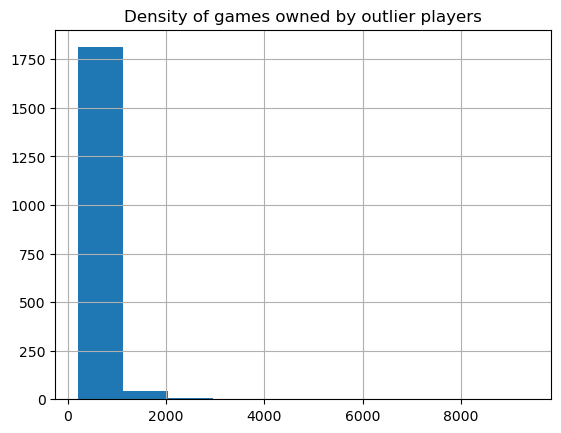

In [21]:
plt.figure()
played_games.groupby(['id'])['game'].count().loc[played_games.groupby(['id'])['game'].count()>200].hist()
plt.title('Density of games owned by outlier players')

Even for outliers, the exponential distribution seems to be verified.

The distributions seem identical to the distributions of the kaggle dataset !